In [2]:
import os
import shutil
from tqdm import tqdm

sample_dir = "sample_5000"     
orig_dir   = "bin_data/images" 
out_dir    = "5000subset"

# create output dir fresh
if os.path.exists(out_dir):
    shutil.rmtree(out_dir)
os.makedirs(out_dir)

sample_files = [f for f in os.listdir(sample_dir)
                if f.lower().endswith(('.jpg','.jpeg','.png'))]

print("sample files:", len(sample_files))

copied = 0

for f in tqdm(sample_files):
    base = os.path.splitext(f)[0]      
    orig_file = base + ".jpg"

    src = os.path.join(orig_dir, orig_file)
    dst = os.path.join(out_dir, orig_file)

    if os.path.exists(src):
        shutil.copy(src, dst)
        copied += 1

print("Copied:", copied)
print("Output folder:", out_dir)


sample files: 5000


100%|████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:18<00:00, 268.05it/s]

Copied: 5000
Output folder: 5000subset


In [3]:
sample_dir = "sample_5000"
subset_dir = "5000subset"

sample_files = sorted([
    os.path.splitext(f)[0]
    for f in os.listdir(sample_dir)
    if f.lower().endswith(('.jpg','.jpeg','.png'))
])

subset_files = sorted([
    os.path.splitext(f)[0]
    for f in os.listdir(subset_dir)
    if f.lower().endswith(('.jpg','.jpeg','.png'))
])

missing = []
matched = []

for name in sample_files:
    if name in subset_files:
        matched.append(name)
    else:
        missing.append(name)

print("TOTAL in sample_5000:", len(sample_files))
print("TOTAL in 5000subset:", len(subset_files))
print("MATCHED:", len(matched))
print("MISSING:", len(missing))

if len(missing) == 0:
    print("\n✔ PERFECT — ALL NAMES MATCH\n")
else:
    print("\n✘ SOME IMAGES MISSING IN 5000subset\n")
    print("Few missing examples:", missing[:10])


TOTAL in sample_5000: 5000
TOTAL in 5000subset: 5000
MATCHED: 5000
MISSING: 0

✔ PERFECT — ALL NAMES MATCH



In [4]:
!pwd


/dgxa_home/se22uari081


In [5]:
!ls


5000subset			   sample_5000
amazon_bin_dataset		   sample5000_EDA.ipynb
amazon_bin.v1i.yolov8.zip	   sample_5000.zip
annotdownload.ipynb		   smartbin_ckpt.pt
asin_to_idx.json		   sub_bin_images.zip
BBtoASIN.ipynb			   sub_metadata.zip
bin_data			   train_metadata.csv
bin_detection_accuracy.csv	   Trial1.ipynb
bin_detection_accuracy_report.csv  Untitled1.ipynb
bin_resnet_multilabel.pth	   Untitled2.ipynb
clip_asin_head.pth		   Untitled.ipynb
clip_yolo_asin_match_report.csv    whole_annotated_from_model
guna.ipynb			   yolo11n.pt
hiii.ipynb			   yolov8m.pt
Please.ipynb			   yolov8s.pt
runs


In [6]:
!ls /dgxa_home/se22uari081


5000subset			   sample_5000
amazon_bin_dataset		   sample5000_EDA.ipynb
amazon_bin.v1i.yolov8.zip	   sample_5000.zip
annotdownload.ipynb		   smartbin_ckpt.pt
asin_to_idx.json		   sub_bin_images.zip
BBtoASIN.ipynb			   sub_metadata.zip
bin_data			   train_metadata.csv
bin_detection_accuracy.csv	   Trial1.ipynb
bin_detection_accuracy_report.csv  Untitled1.ipynb
bin_resnet_multilabel.pth	   Untitled2.ipynb
clip_asin_head.pth		   Untitled.ipynb
clip_yolo_asin_match_report.csv    whole_annotated_from_model
guna.ipynb			   yolo11n.pt
hiii.ipynb			   yolov8m.pt
Please.ipynb			   yolov8s.pt
runs


In [43]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import cv2

In [44]:
IMG_DIR = "/dgxa_home/se22uari081/5000subset"

In [45]:
def estimate_blur(arr):
    """
    Measures blur level using pixel gradients.
    Larger value = sharper
    Lower value = blurrier
    """
    gy, gx = np.gradient(arr.astype(np.float32), axis=(0,1))
    return (np.abs(gx) + np.abs(gy)).mean()


In [46]:
def estimate_dark_ratio(arr):
    """ percentage of pixels below threshold """
    return np.mean(arr < 25)

In [47]:
def estimate_bright_ratio(arr):
    """ percentage of pixels above threshold """
    return np.mean(arr > 230)

In [48]:
# ------------------------------------------------------------
# Scan all images, compute metrics
# ------------------------------------------------------------

records = []
files = [f for f in os.listdir(IMG_DIR) if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.webp'))]

for f in tqdm(files, desc="Scanning images"):
    path = os.path.join(IMG_DIR, f)

    try:
        im = Image.open(path).convert("RGB")
    except UnidentifiedImageError:
        continue

    w, h = im.size
    arr = np.array(im)

    brightness = arr.mean()
    blur = estimate_blur(arr)
    dark_ratio = estimate_dark_ratio(arr)
    bright_ratio = estimate_bright_ratio(arr)

    records.append({
        "filename": f,
        "path": path,
        "width": w,
        "height": h,
        "aspect": w/h,
        "brightness": brightness,
        "blur": blur,
        "dark_ratio": dark_ratio,
        "bright_ratio": bright_ratio,
    })


df = pd.DataFrame(records)

print("Total images scanned:", len(df))
df.head()

Scanning images: 100%|███████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 128.94it/s]

Total images scanned: 5000


,filename,path,width,height,aspect,brightness,blur,dark_ratio,bright_ratio
0,346366.jpg,/dgxa_home/se22uari081/5000subset/346366.jpg,348,237,1.468354,130.541232,10.233215,0.000000,0.011506
1,433616.jpg,/dgxa_home/se22uari081/5000subset/433616.jpg,640,475,1.347368,124.689434,5.765783,0.000012,0.006522
2,374909.jpg,/dgxa_home/se22uari081/5000subset/374909.jpg,452,399,1.132832,92.481061,7.204843,0.000201,0.000493
3,213946.jpg,/dgxa_home/se22uari081/5000subset/213946.jpg,366,553,0.661844,91.533365,6.814427,0.000102,0.000000
4,362324.jpg,/dgxa_home/se22uari081/5000subset/362324.jpg,376,256,1.468750,134.809951,5.523043,0.000007,0.000461


In [49]:
df.describe()


,width,height,aspect,brightness,blur,dark_ratio,bright_ratio
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,475.006000,422.684200,1.232684,112.752645,6.554251,0.000126,0.007693
std,108.397622,178.403825,0.330644,17.184229,2.289462,0.000854,0.013802
min,310.000000,227.000000,0.603205,58.088768,1.281159,0.000000,0.000000
25%,382.000000,284.000000,1.031455,101.265211,4.882108,0.000000,0.000016
50%,449.000000,344.000000,1.306407,112.754337,6.422988,0.000008,0.001209
75%,550.000000,551.000000,1.465863,124.370312,8.072343,0.000058,0.008891
max,1100.000000,1171.000000,2.126344,174.494130,15.246499,0.023982,0.184045


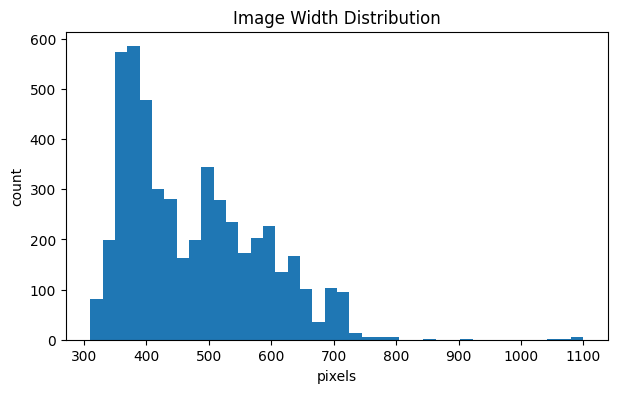

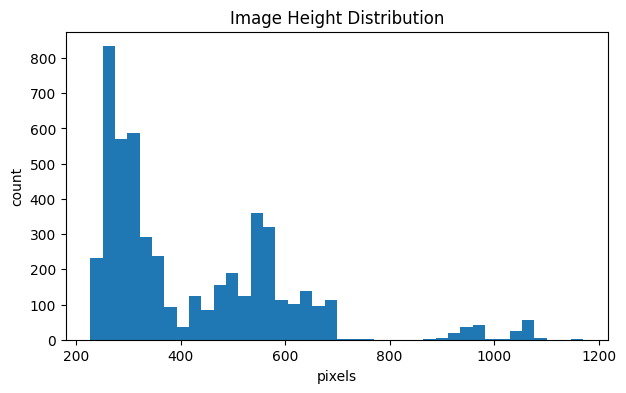

In [50]:
#RESOLUTION ANALYSIS
plt.figure(figsize=(7,4))
plt.hist(df["width"], bins=40)
plt.title("Image Width Distribution")
plt.xlabel("pixels")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(df["height"], bins=40)
plt.title("Image Height Distribution")
plt.xlabel("pixels")
plt.ylabel("count")
plt.show()


In [51]:
#ASPECT RATIO ANALYSIS

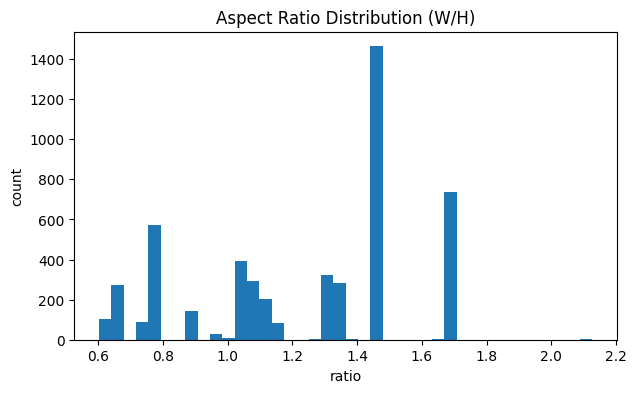

In [52]:
plt.figure(figsize=(7,4))
plt.hist(df["aspect"], bins=40)
plt.title("Aspect Ratio Distribution (W/H)")
plt.xlabel("ratio")
plt.ylabel("count")
plt.show()


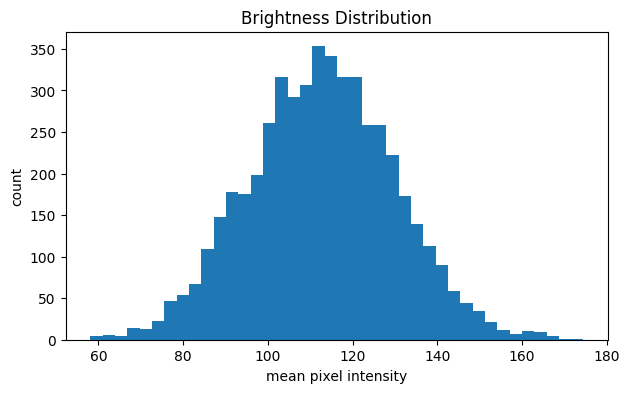

In [53]:
#BRIGHTNESS ANALYSIS
plt.figure(figsize=(7,4))
plt.hist(df["brightness"], bins=40)
plt.title("Brightness Distribution")
plt.xlabel("mean pixel intensity")
plt.ylabel("count")
plt.show()


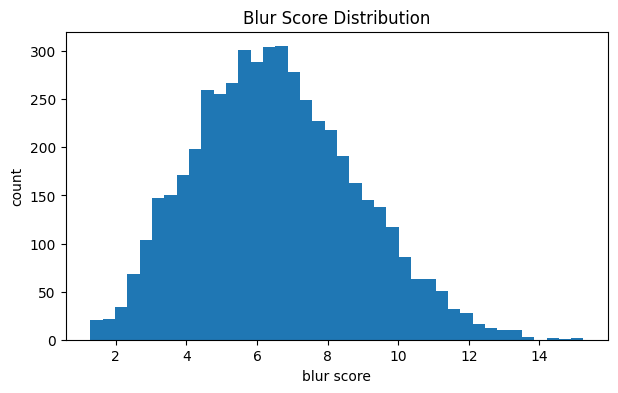

In [54]:
#BLUR / SHARPNESS ANALYSIS
plt.figure(figsize=(7,4))
plt.hist(df["blur"], bins=40)
plt.title("Blur Score Distribution")
plt.xlabel("blur score")
plt.ylabel("count")
plt.show()


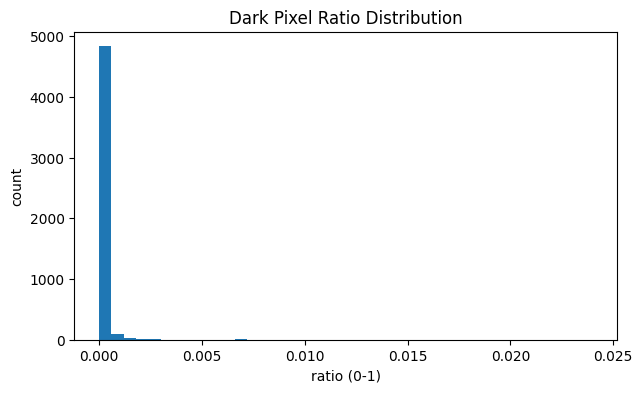

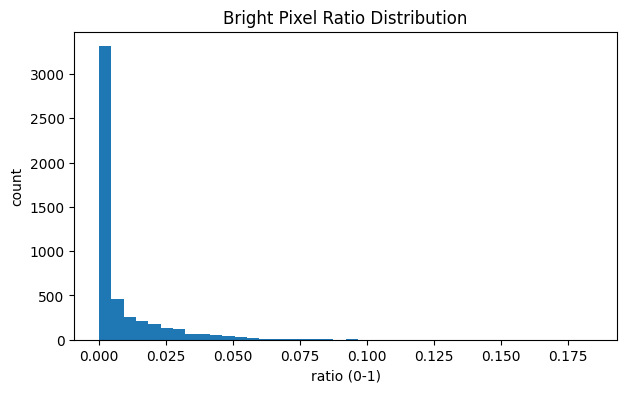

In [55]:
#DARK / OVEREXPOSED ANALYSIS
plt.figure(figsize=(7,4))
plt.hist(df["dark_ratio"], bins=40)
plt.title("Dark Pixel Ratio Distribution")
plt.xlabel("ratio (0-1)")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(df["bright_ratio"], bins=40)
plt.title("Bright Pixel Ratio Distribution")
plt.xlabel("ratio (0-1)")
plt.ylabel("count")
plt.show()


In [56]:
#OUTLIER DISCOVERY
print("Very dark images (< 20% brightness):", len(df[df["brightness"] < 40]))
print("Very bright images (> 230 brightness):", len(df[df["brightness"] > 230]))
print("Highly blurry images:", len(df[df["blur"] < df['blur'].quantile(0.05)]))


Very dark images (< 20% brightness): 0
Very bright images (> 230 brightness): 0
Highly blurry images: 250


In [57]:
df.to_csv("5000subset_EDA_report.csv", index=False)
print("Saved: 5000subset_EDA_report.csv")


Saved: 5000subset_EDA_report.csv


In [58]:
import seaborn as sns
from skimage import filters, color, segmentation, measure

In [59]:
IMAGE_DIR = "5000subset"

In [60]:
def load_image(path):
    """
    Loads image using OpenCV & converts BGR -> RGB.
    Returns None if fails.
    """
    img = cv2.imread(path)
    if img is None:
        return None
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



In [61]:
def compute_brightness(img):
    """
    Mean pixel intensity (0–255).
    Measures global illumination.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray.mean()


In [62]:
def compute_contrast(img):
    """
    Standard deviation of grayscale intensity.
    Higher means more detail variations.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray.std()


In [63]:
def compute_sharpness(img):
    """
    Laplacian variance → classical blur metric.
    Higher = sharper
    Lower = blurrier
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

In [64]:

def compute_color_entropy(img):
    """
    Color entropy measures variation in chroma.
    Higher entropy → more mixed colors → harder detection.
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([hsv], [1], None, [256], [0,256])
    hist = hist / hist.sum()
    return -np.sum(hist * np.log2(hist + 1e-8))

In [65]:
def compute_clutter(img):
    """
    Canny-based edge density percentage
    Higher = more cluttered bin
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    return edges.mean()

In [66]:
def estimate_tape_obstruction(img):
    """
    Tape usually at front top edge.
    We measure bright pixels ratio in top 20% region.
    """
    H = img.shape[0]
    top_region = img[:int(0.2 * H), :, :]
    gray = cv2.cvtColor(top_region, cv2.COLOR_RGB2GRAY)
    bright_mask = gray > 200
    return bright_mask.mean()

In [67]:
def estimate_perspective_distortion(img):
    """
    Uses HoughLines on edges to derive skew angle deviation.
    Higher = more skewed perspective.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 80, 200)

    lines = cv2.HoughLines(edges, 1, np.pi/180, 120)
    if lines is None:
        return 0

    angles = []
    for ln in lines[:30]:  # limit to avoid slowdown
        rho, theta = ln[0]
        angle_d = abs(theta * 180 / np.pi - 90)
        angles.append(angle_d)

    return np.mean(angles) if angles else 0

In [68]:
#running EDA
records = []

print("Running image-level EDA on:", IMAGE_DIR)

for fname in tqdm(os.listdir(IMAGE_DIR)):
    if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
        continue
    
    path = os.path.join(IMAGE_DIR, fname)
    img = load_image(path)
    if img is None:
        continue
    
    h, w = img.shape[:2]

    rec = {
        "image_id": fname.rsplit(".",1)[0],
        "width": w,
        "height": h,
        "aspect_ratio": w/h,

        "brightness": compute_brightness(img),
        "contrast": compute_contrast(img),
        "sharpness": compute_sharpness(img),
        
        "clutter": compute_clutter(img),
        "color_entropy": compute_color_entropy(img),

        "tape_obstruction": estimate_tape_obstruction(img),
        "perspective_distortion": estimate_perspective_distortion(img),
    }

    records.append(rec)


df_img = pd.DataFrame(records)
df_img.head()

Running image-level EDA on: 5000subset


100%|█████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:06<00:00, 75.75it/s]


,image_id,width,height,aspect_ratio,brightness,contrast,sharpness,clutter,color_entropy,tape_obstruction,perspective_distortion
0,346366,348,237,1.468354,135.155039,32.239796,288.378828,25.977375,6.576781,0.102348,1.115382
1,433616,640,475,1.347368,129.837809,37.770681,126.799479,12.213997,6.796062,0.034655,1.199999
2,374909,452,399,1.132832,94.852774,37.759042,121.031469,18.013507,6.644194,0.000000,0.766665
3,213946,366,553,0.661844,94.775729,25.851545,99.692152,8.006626,6.586612,0.000000,9.937497
4,362324,376,256,1.468750,139.564879,28.585212,49.306870,5.308968,5.940887,0.004485,1.333326


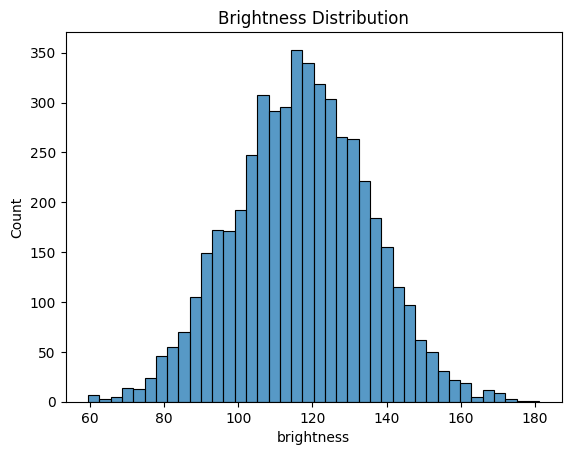

In [69]:
sns.histplot(df_img["brightness"], bins=40)
plt.title("Brightness Distribution")
plt.show()

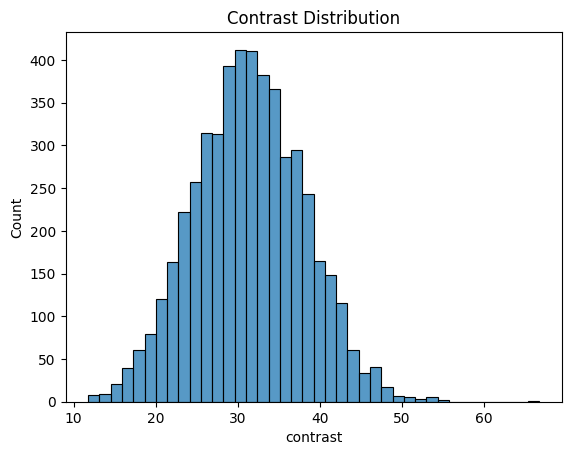

In [70]:
sns.histplot(df_img["contrast"], bins=40)
plt.title("Contrast Distribution")
plt.show()

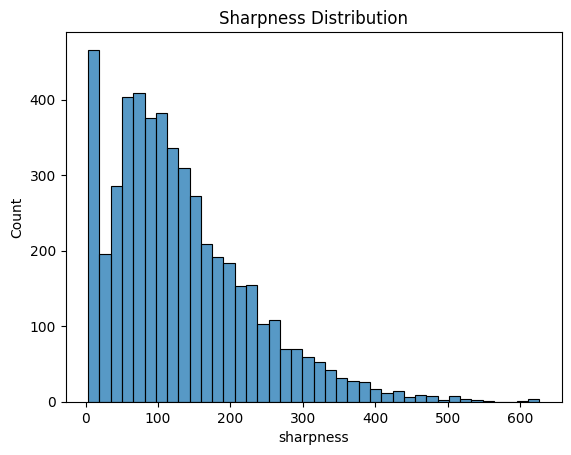

In [71]:
sns.histplot(df_img["sharpness"], bins=40)
plt.title("Sharpness Distribution")
plt.show()

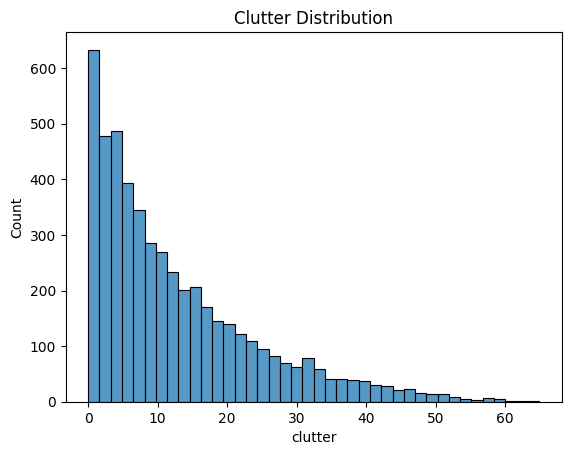

In [72]:
sns.histplot(df_img["clutter"], bins=40)
plt.title("Clutter Distribution")
plt.show()

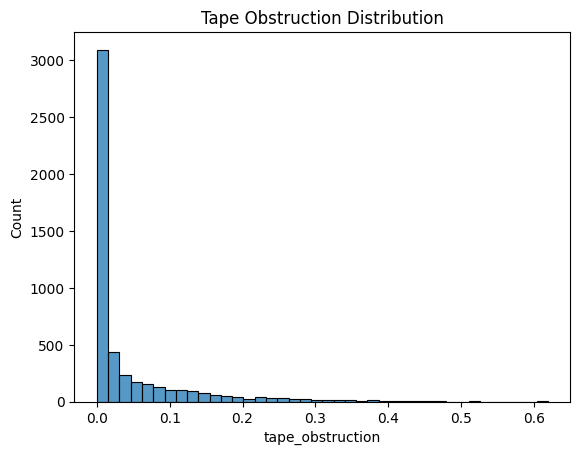

In [73]:
sns.histplot(df_img["tape_obstruction"], bins=40)
plt.title("Tape Obstruction Distribution")
plt.show()

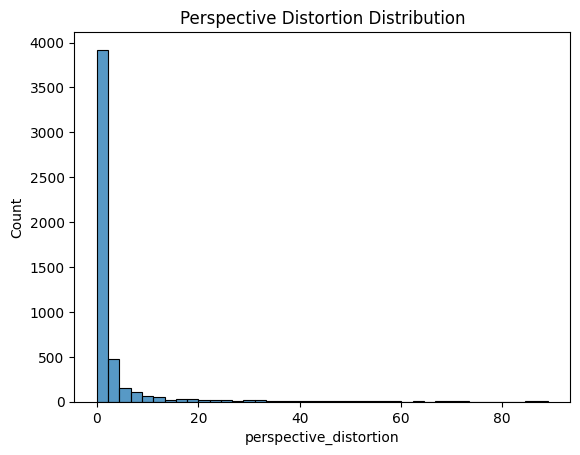

In [74]:
sns.histplot(df_img["perspective_distortion"], bins=40)
plt.title("Perspective Distortion Distribution")
plt.show()

In [75]:
#Feature Normalization + Hardness Score
feat_cols = [
    "clutter", 
    "sharpness", 
    "brightness",
    "contrast",
    "tape_obstruction",
    "perspective_distortion"
]

In [76]:
df_norm = df_img.copy()

# normalize each feature
for col in feat_cols:
    df_norm[col+"_norm"] = (df_img[col] - df_img[col].min()) / (df_img[col].max() - df_img[col].min())



In [77]:
# domain-aware hardness score
df_norm["hardness"] = (
    0.25 * df_norm["clutter_norm"] +
    0.25 * (1 - df_norm["sharpness_norm"]) +   # blur increases hardness
    0.10 * (1 - df_norm["brightness_norm"]) + 
    0.10 * df_norm["tape_obstruction_norm"] +
    0.15 * df_norm["perspective_distortion_norm"] +
    0.15 * (1 - df_norm["contrast_norm"])
)

df_norm.sort_values("hardness", ascending=False).head(20)

,image_id,width,height,aspect_ratio,brightness,contrast,sharpness,clutter,color_entropy,tape_obstruction,perspective_distortion,clutter_norm,sharpness_norm,brightness_norm,contrast_norm,tape_obstruction_norm,perspective_distortion_norm,hardness
1020,407255,574,547,1.049360,107.440413,20.952856,31.778298,1.066365,5.747769,0.011891,88.000000,0.016432,0.045289,0.393844,0.166894,0.019199,0.988764,0.578602
3602,189335,458,586,0.781570,94.696127,23.739437,51.089341,1.742515,6.246998,0.000000,86.750000,0.026850,0.076295,0.288964,0.217603,0.000000,0.974719,0.572310
4941,323097,590,571,1.033275,93.835528,29.182607,50.270023,3.010285,6.544695,0.000000,89.000000,0.046385,0.074980,0.281881,0.316655,0.000000,1.000000,0.567165
1446,106451,722,657,1.098935,115.891214,28.915750,39.525289,3.644209,5.773122,0.000000,88.250000,0.056154,0.057728,0.463390,0.311799,0.000000,0.991573,0.555234
2695,363748,461,354,1.302260,110.692820,22.098800,135.088392,5.418949,6.245407,0.000000,86.999985,0.083501,0.211166,0.420610,0.187747,0.000000,0.977528,0.544490
3423,285880,436,559,0.779964,104.975037,27.956822,63.881696,7.069616,6.155640,0.009980,71.090912,0.108936,0.096835,0.373555,0.294349,0.016113,0.798774,0.542945
1034,391369,494,562,0.879004,134.089332,28.464413,30.324249,1.414483,5.790813,0.002910,89.000000,0.021796,0.042954,0.613153,0.303586,0.004698,1.000000,0.538327
2764,190433,440,388,1.134021,97.029042,29.194141,96.202707,11.752226,6.489152,0.000000,60.000000,0.181090,0.148731,0.308162,0.316865,0.000000,0.674157,0.530867
1720,150389,643,1064,0.604323,112.071655,29.600386,64.467505,7.404539,6.301218,0.000000,68.538460,0.114097,0.097776,0.431957,0.324258,0.000000,0.770095,0.527760
4624,07406,640,1061,0.603205,76.187946,26.150124,34.364435,2.259189,6.636665,0.000000,49.777779,0.034812,0.049441,0.136649,0.261472,0.000000,0.559301,0.527352


In [78]:

OUTPUT_CSV = "image_EDA_full.csv"

df_norm.to_csv(OUTPUT_CSV, index=False)

print("✔ Saved to:", OUTPUT_CSV)
print("Total rows:", len(df_norm))
print("Columns:", list(df_norm.columns))

✔ Saved to: image_EDA_full.csv
Total rows: 5000
Columns: ['image_id', 'width', 'height', 'aspect_ratio', 'brightness', 'contrast', 'sharpness', 'clutter', 'color_entropy', 'tape_obstruction', 'perspective_distortion', 'clutter_norm', 'sharpness_norm', 'brightness_norm', 'contrast_norm', 'tape_obstruction_norm', 'perspective_distortion_norm', 'hardness']
